/data/users2/jwardell1/undersampling-project/OULU/pkl-files/FBIRN


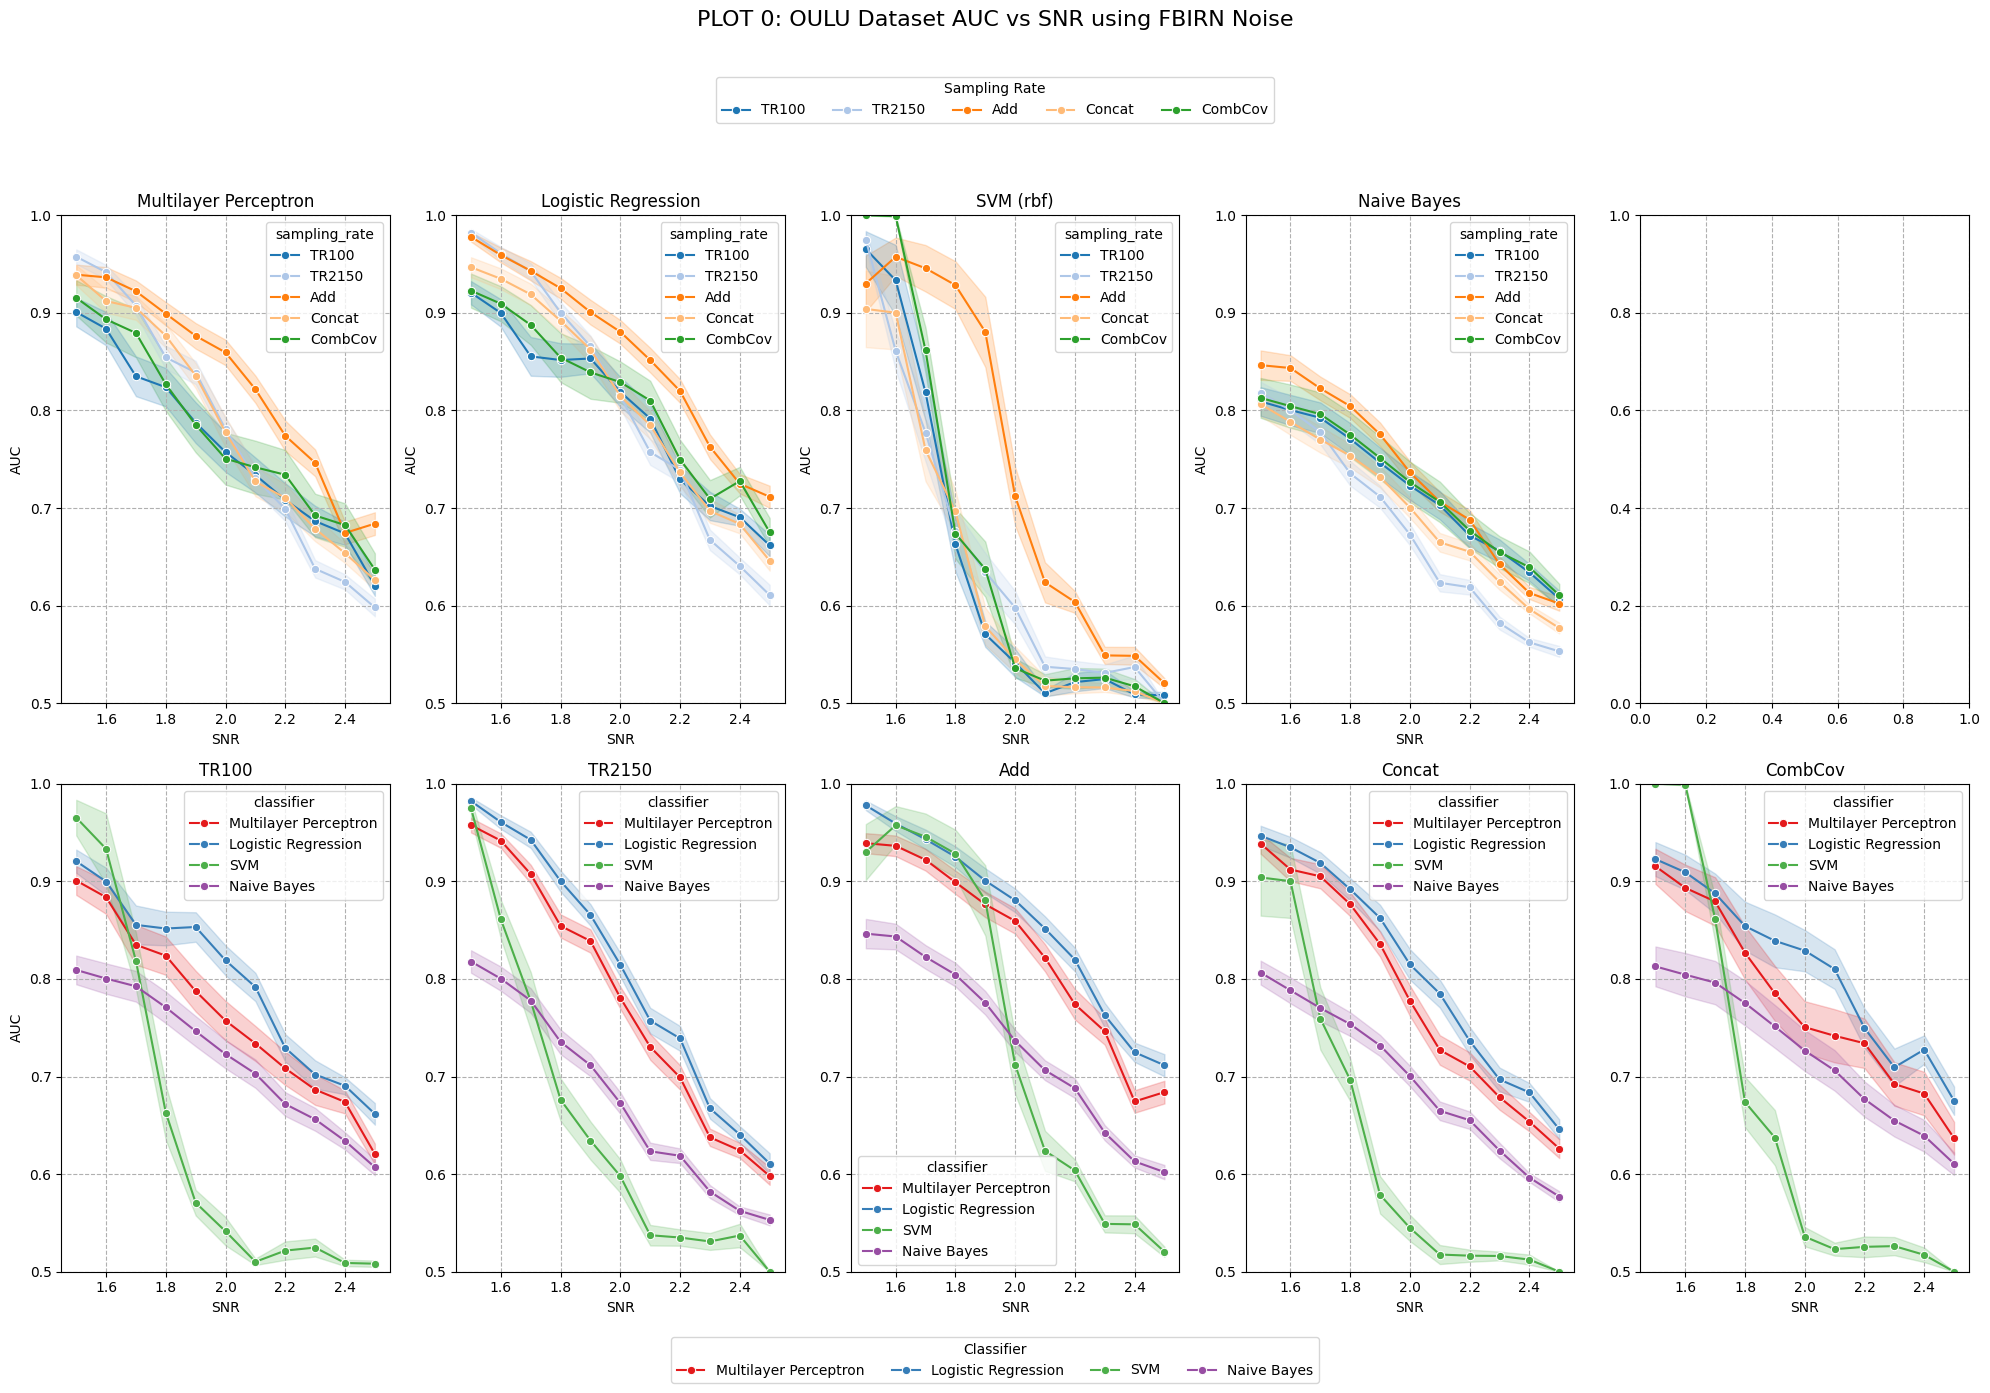

In [51]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import numpy as np


signal_dataset = 'oulu'
noise_dataset = 'fbirn'

plot_all = False

kernel_type = 'rbf'
sklearn = False




def plot(noise_dataset, signal_dataset, sklearn, kernel_type, plot_no):

    # Define the directory for the current undersampling rate
    pkl_dir = f'/data/users2/jwardell1/undersampling-project/{signal_dataset.upper()}/pkl-files/{noise_dataset.upper()}'
    print(pkl_dir)

    if sklearn:
        joined_files = os.path.join(f'{pkl_dir}/SVM/sklearn', f'*{kernel_type}*.pkl')
    else:
        joined_files = os.path.join(f'{pkl_dir}/SVM/10-03', f'*{kernel_type}*.pkl')
    joined_list = glob.glob(joined_files)
    #print(joined_list)
    thundersvm_df = pd.concat((pd.read_pickle(file).assign(classifier='SVM') for file in joined_list), ignore_index=True)





    # Read and concatenate sr1 data
    joined_files = os.path.join(pkl_dir, 'sr1_*.pkl')
    joined_list = glob.glob(joined_files)
    sr1 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr1') for file in joined_list), ignore_index=True)

    # Read and concatenate sr2 data
    joined_files = os.path.join(pkl_dir, 'sr2_*.pkl')
    joined_list = glob.glob(joined_files)
    sr2 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr2') for file in joined_list), ignore_index=True)

    # Read and concatenate concat data
    joined_files = os.path.join(pkl_dir, 'concat_*.pkl')
    joined_list = glob.glob(joined_files)
    concat = pd.concat((pd.read_pickle(file).assign(sampling_rate='concat') for file in joined_list), ignore_index=True)

    # Read and concatenate add data
    joined_files = os.path.join(pkl_dir, 'add_*.pkl')
    joined_list = glob.glob(joined_files)
    add = pd.concat((pd.read_pickle(file).assign(sampling_rate='add') for file in joined_list), ignore_index=True)


    # Read and concatenate add data
    joined_files = os.path.join(pkl_dir, 'combcov_*.pkl')
    joined_list = glob.glob(joined_files)
    CombCov = pd.concat((pd.read_pickle(file).assign(sampling_rate='combcov') for file in joined_list), ignore_index=True)


    # Concatenate all dataframes
    all_data = pd.concat([sr1, sr2, concat, add, CombCov], ignore_index=True)

    # Function to split each row into multiple rows based on cross-validation index
    def split_row(row):
        new_rows = []
        for cv_ix, auc in enumerate(row['test_scores']):
            new_row = row.copy()
            new_row['auc'] = auc
            new_row['cv_ix'] = cv_ix
            new_rows.append(new_row)
        return pd.DataFrame(new_rows)


    all_data = all_data.dropna(subset=['test_scores'])

    # Apply the split_row function to each row of the dataframe and concatenate the results
    result_df = pd.concat(all_data.apply(split_row, axis=1).tolist(), ignore_index=True)

    # Drop the original 'test_scores' column as it's no longer needed
    result_df.drop('test_scores', axis=1, inplace=True)





    # Load thundersvm_df_linear and rename 'roc' column to 'auc'
    thundersvm_df.rename(columns={'roc': 'auc'}, inplace=True)
    thundersvm_df.rename(columns={'fold': 'cv_ix'}, inplace=True)
    thundersvm_df.rename(columns={'noise_ix': 'noise_no'}, inplace=True)
    #thundersvm_df_rbf.rename(columns={'fbirn_sub': 'graph_no'}, inplace=True)




    # Filter and clean up thundersvm_df_linear
    thundersvm_df_linear = thundersvm_df[['snr', 'cv_ix', 'auc', 'sampling_rate', 'classifier']]#'noise_no']#'graph_no', 'classifier']]
    thundersvm_df_linear = thundersvm_df.replace([np.inf, -np.inf], np.nan).dropna()




    result_df = result_df[['snr', 'cv_ix', 'auc', 'sampling_rate', 'noise_no', 'classifier']]# 'graph_no', 'classifier']]




    # Merge with thundersvm_df_linear
    result_df = pd.concat([result_df, thundersvm_df_linear], ignore_index=True)



    result_df['sampling_rate'] = result_df['sampling_rate'].replace('add', 'Add')
    result_df['sampling_rate'] = result_df['sampling_rate'].replace('concat', 'Concat')
    result_df['sampling_rate'] = result_df['sampling_rate'].replace('combcov', 'CombCov')
    result_df['sampling_rate'] = result_df['sampling_rate'].replace('sr1', 'TR100')
    result_df['sampling_rate'] = result_df['sampling_rate'].replace('sr2', 'TR2150')


    result_df = result_df[result_df['snr'] <= 3]


    ###########################################################################################################################

    grouped_classifiers = result_df.groupby('classifier')

    classifier_dfs = {}
    for classifier, group_df in grouped_classifiers:
        classifier_dfs[classifier] = group_df.copy()

    mlp_df = classifier_dfs.get('Multilayer Perceptron', pd.DataFrame())
    lr_df = classifier_dfs.get('Logistic Regression', pd.DataFrame())
    svm_df = classifier_dfs.get('SVM', pd.DataFrame())
    nb_df = classifier_dfs.get('Naive Bayes', pd.DataFrame())

    dfs = [mlp_df, lr_df, svm_df, nb_df]
    classifiers = ['Multilayer Perceptron', 'Logistic Regression', 'SVM', 'Naive Bayes']
    sampling_rates = ['TR100', 'TR2150', 'Add', 'Concat', 'CombCov']
    hue_order = sampling_rates
    palette = {item: plt.cm.tab20(i) for i, item in enumerate(sampling_rates)}

    # Combine all dataframes into one dataframe for plotting
    combined_df = pd.concat(dfs)
    snr_levels = [1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]



    # Define your variables
    x = "snr"
    y = "auc"
    hue = "sampling_rate"
    order = snr_levels

    # Create the figure and the axes
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 12), gridspec_kw={'height_ratios': [1, 1]})

    # Collect y-limits for determining the common range
    all_y_vals = []

    # Plot the first row with sampling_rate as hue
    for i, classifier in enumerate(classifiers):
        # Filter the data for the current classifier
        data_filtered = combined_df[combined_df['classifier'] == classifier]

        # Lineplot with error bands
        summary_df = data_filtered.groupby([x, hue]).agg(
            mean_auc=(y, 'mean'),
            std_auc=(y, 'std'),
            count=(y, 'count')
        ).reset_index()
        summary_df['se_auc'] = summary_df['std_auc'] / np.sqrt(summary_df['count'])
        
        sns.lineplot(
            data=summary_df, x=x, y='mean_auc', hue=hue, hue_order=hue_order,
            palette=palette, marker='o', ax=axes[0, i]
        )
        
        # Add error bands manually
        for key, grp in summary_df.groupby(hue):
            color = palette[key]
            axes[0, i].fill_between(grp[x], grp['mean_auc'] - grp['se_auc'], grp['mean_auc'] + grp['se_auc'], color=color, alpha=0.2)
        
        if classifier == 'SVM':
            axes[0, i].set_title(f'{classifier} ({kernel_type})')
        else:
            axes[0, i].set_title(f'{classifier}')
        axes[0, i].set_ylim(0.5, 1)  # Setting y-limit
        axes[0, i].set_xlabel('SNR')
        axes[0, i].set_ylabel('AUC')


    # Adjust hue_order and palette for the second row
    hue_order = classifiers
    classifier_palette = sns.color_palette("Set1", len(classifiers))
    palette = {item: classifier_palette[i] for i, item in enumerate(classifiers)}

    # Plot the second row with classifier as hue
    for i, sampling_rate in enumerate(sampling_rates):
        # Filter the data for the current sampling rate
        data_filtered = combined_df[combined_df['sampling_rate'] == sampling_rate]

        # Lineplot with error bands
        summary_df = data_filtered.groupby([x, 'classifier']).agg(
            mean_auc=(y, 'mean'),
            std_auc=(y, 'std'),
            count=(y, 'count')
        ).reset_index()
        summary_df['se_auc'] = summary_df['std_auc'] / np.sqrt(summary_df['count'])
        
        sns.lineplot(
            data=summary_df, x=x, y='mean_auc', hue='classifier', hue_order=hue_order,
            palette=palette, marker='o', ax=axes[1, i]
        )
        
        # Add error bands manually
        for key, grp in summary_df.groupby('classifier'):
            color = palette[key]
            axes[1, i].fill_between(grp[x], grp['mean_auc'] - grp['se_auc'], grp['mean_auc'] + grp['se_auc'], color=color, alpha=0.2)
        
        # Collect y-values
        all_y_vals.extend(data_filtered[y].values)
        
        axes[1, i].set_title(f'{sampling_rate}')
        axes[1, i].set_ylim(0.5, 1)  # Setting y-limit
        axes[1, i].set_xlabel('SNR')
        if i == 0:
            axes[1, i].set_ylabel('AUC')
        else:
            axes[1, i].set_ylabel('')



    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Add a super title
    #fig.suptitle(f"Finnish Dataset AUC vs SNR using FBIRN subject {subID} Noise", fontsize=16, y=1.10)
    fig.suptitle(f"PLOT {plot_no}: {signal_dataset.upper()} Dataset AUC vs SNR using {noise_dataset.upper()} Noise", fontsize=16, y=1.10)

    # Add grid
    for ax_row in axes:
        for ax in ax_row:
            ax.grid(True, which='both', axis='both', linestyle='--')

    # Add legends
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(sampling_rates), title='Sampling Rate', bbox_to_anchor=(0.5, 1.05))

    handles, labels = axes[1, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(classifiers), title='Classifier', bbox_to_anchor=(0.5, -0.05))
    plt.savefig(f'../results/{signal_dataset}_{noise_dataset}_{kernel_type}.png')

    plt.show()

if plot_all:
    signal_datasets = ['oulu', 'hcp']
    noise_datasets = ['fbirn', 'cobre', 'var']
    kernels = ['rbf']#, 'linear']
    plot_no = 0

    for signal_dataset in signal_datasets:
        for noise_dataset in noise_datasets:
            for kernel_type in kernels:
                try:
                    plot(noise_dataset, signal_dataset, sklearn, kernel_type, plot_no)
                    plot_no += 1
                except ValueError as e:
                    pass
                    #print(f'error poltting {signal_dataset} {noise_dataset} {kernel_type} sklearn {sklearn}')

else:
    plot_no = 0
    plot(noise_dataset, signal_dataset, sklearn, kernel_type, plot_no)

Text(0.5, 1.0, 'Pairwise Distances SR1 at SNR 1.5')

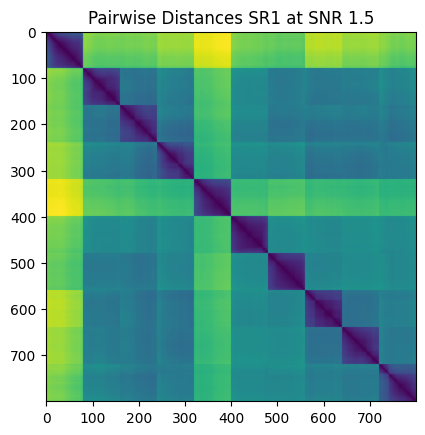

In [17]:
dfs = {
    'SR1': sr1_data, 
    'SR2': sr2_data, 
    'Add': add_data
}

sr = 'SR1'
df = pd.DataFrame(dfs[sr])
X_n, y_n, g_n = parse_X_y_groups(df[df['target'] == '1'], sr)
X, y, g = parse_X_y_groups(df[df['target'] == '0'], sr)
plt.clf()
plt.imshow(cdist(X_n, X, 'euclidean'))
plt.title(f'Pairwise Distances {sr} at SNR {SNR}')

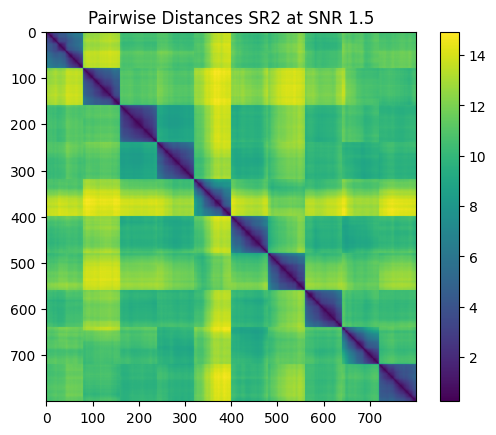

In [49]:
sr = 'SR2'
df = pd.DataFrame(dfs[sr])
X_n, y_n, g_n = parse_X_y_groups(df[df['target'] == '1'], sr)
X, y, g = parse_X_y_groups(df[df['target'] == '0'], sr)
plt.clf()
plt.imshow(cdist(X_n, X, 'euclidean'))
plt.title(f'Pairwise Distances {sr} at SNR {SNR}')
plt.colorbar()

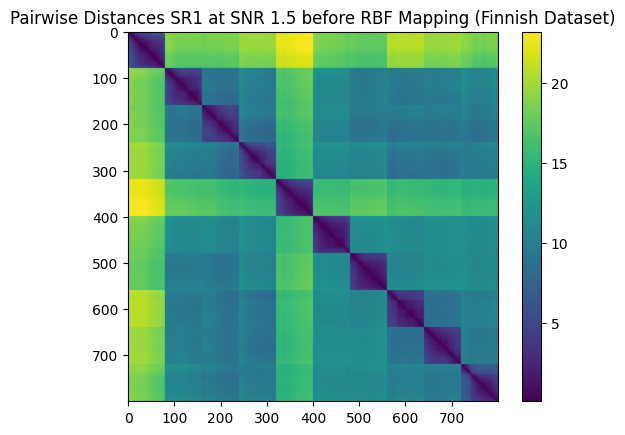

In [54]:
sr = 'SR1'
df = pd.DataFrame(dfs[sr])
X_n, y_n, g_n = parse_X_y_groups(df[df['target'] == '1'], sr)
X, y, g = parse_X_y_groups(df[df['target'] == '0'], sr)
plt.clf()
plt.imshow(cdist(X_n, X, 'euclidean'))
plt.title(f'Pairwise Distances {sr} at SNR {SNR} before RBF Mapping (Finnish Dataset)')
plt.colorbar()

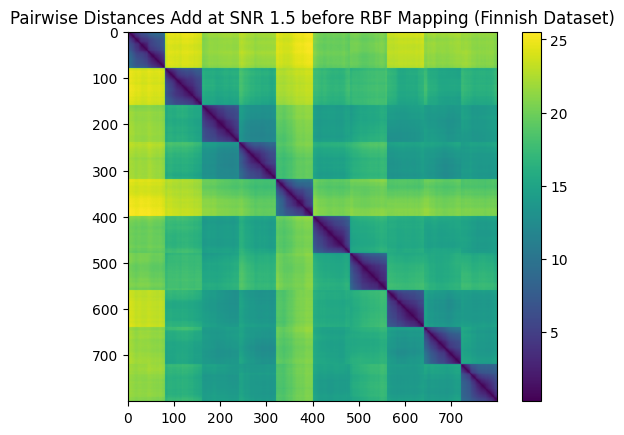

In [50]:
sr = 'Add'
df = pd.DataFrame(dfs[sr])
X_n, y_n, g_n = parse_X_y_groups(df[df['target'] == '1'], sr)
X, y, g = parse_X_y_groups(df[df['target'] == '0'], sr)
plt.clf()
plt.imshow(cdist(X_n, X, 'euclidean'))
plt.title(f'Pairwise Distances {sr} at SNR {SNR} before RBF Mapping (Finnish Dataset)')
plt.colorbar()

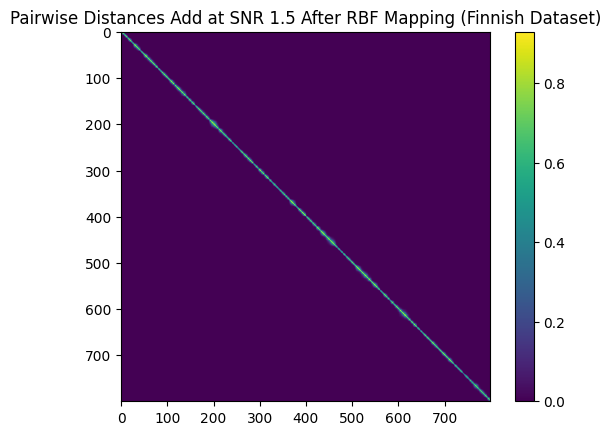

In [51]:
X_n_rbf = rbf_kernel(X_n, X, gamma=gamma)
plt.clf()
plt.imshow(X_n_rbf)
plt.title(f'Pairwise Distances {sr} at SNR {SNR} After RBF Mapping (Finnish Dataset)')
plt.colorbar()

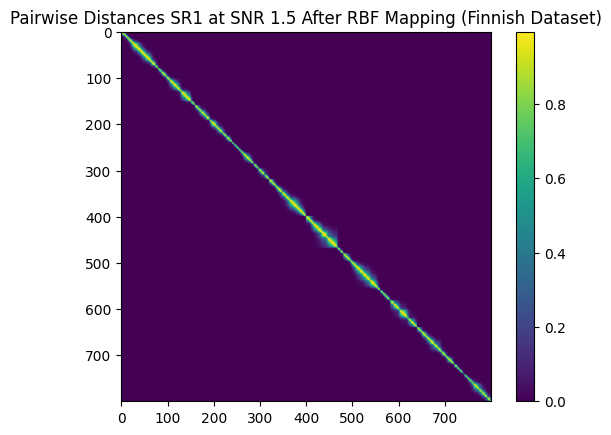

In [52]:
sr = 'SR1'
df = pd.DataFrame(dfs[sr])
X_n, y_n, g_n = parse_X_y_groups(df[df['target'] == '1'], sr)
X, y, g = parse_X_y_groups(df[df['target'] == '0'], sr)

X_n_rbf = rbf_kernel(X_n, X, gamma=gamma)
plt.clf()
plt.imshow(X_n_rbf)
plt.title(f'Pairwise Distances {sr} at SNR {SNR} After RBF Mapping (Finnish Dataset)')
plt.colorbar()

Basic Descriptive Statistics
Min value: 1.4781426306619394e-234
Max value: 0.9944939660996869
Mean value: 0.01312474467230254
Standard Deviation: 0.09054116660166273
Non-diagonal min: 1.4781426306619394e-234
Non-diagonal max: 0.980985047333715
Non-diagonal mean: 0.011902715607568644


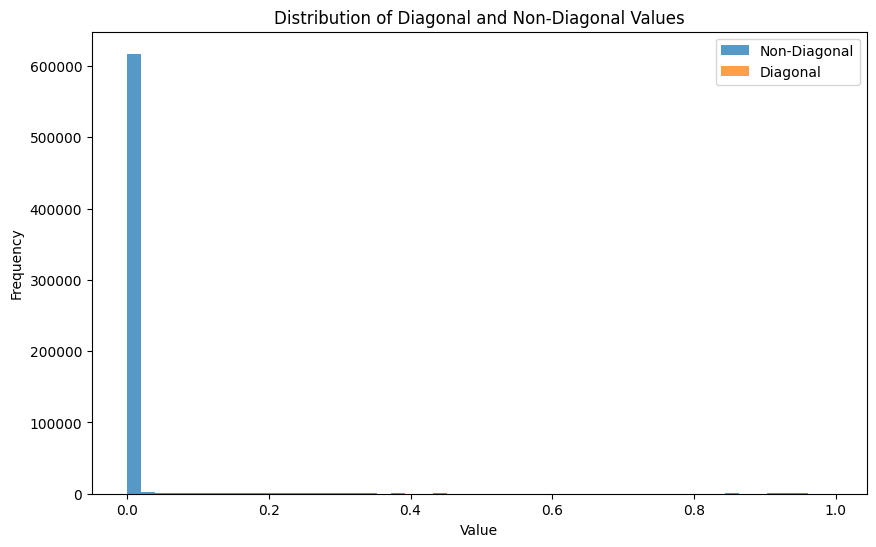

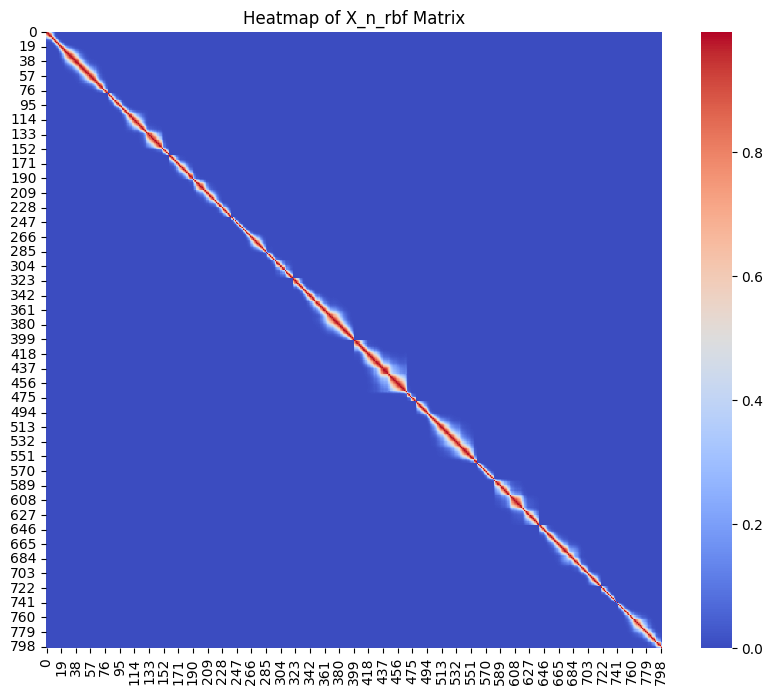

Row 100 Values: [4.27012970e-156 2.80945787e-156 9.09230504e-158 4.36907096e-158
 1.25817298e-159 9.79991972e-160 2.04865211e-160 2.12045617e-157
 2.51429151e-158 2.12062721e-156 2.87472255e-155 6.73422367e-154
 2.12809515e-154 3.93302992e-154 4.34599301e-154 1.90479985e-153
 2.53811382e-153 1.34799622e-151 1.83200432e-152 2.90182212e-151
 5.30444458e-152 1.49885538e-151 2.55380459e-152 1.19611087e-150
 7.25470720e-152 5.71725815e-151 3.25963201e-152 9.56103900e-152
 2.92371060e-151 5.92927439e-151 3.75566700e-151 1.34371303e-150
 3.58836790e-151 4.51310779e-151 1.40816552e-150 8.17298823e-150
 1.61665459e-149 3.35979563e-148 2.58122436e-148 1.67273611e-147
 6.17080228e-147 1.69931003e-146 8.77991581e-145 2.14113466e-143
 4.38223139e-142 3.37446578e-141 1.54019476e-140 5.00782184e-140
 1.49406317e-139 3.07368002e-138 4.10997740e-138 1.85996008e-137
 1.40546604e-137 9.38774417e-136 8.67832902e-136 7.66642187e-134
 2.53947984e-133 6.36975967e-133 3.65029760e-133 2.75840120e-133
 1.502915

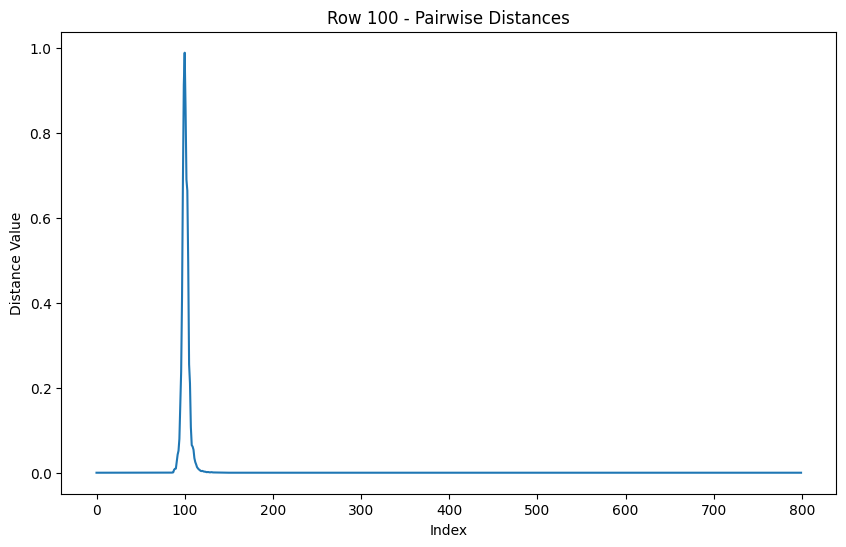

In [53]:
import seaborn as sns

# 1. Basic Descriptive Statistics
print("Basic Descriptive Statistics")
min_value = np.min(X_n_rbf)
max_value = np.max(X_n_rbf)
mean_value = np.mean(X_n_rbf)
std_value = np.std(X_n_rbf)

print(f"Min value: {min_value}")
print(f"Max value: {max_value}")
print(f"Mean value: {mean_value}")
print(f"Standard Deviation: {std_value}")

# 2. Extract Diagonal and Non-Diagonal Elements
diagonal_elements = np.diag(X_n_rbf)
non_diagonal_elements = X_n_rbf[~np.eye(X_n_rbf.shape[0], dtype=bool)]  # Extract non-diagonal elements

# Basic statistics of non-diagonal elements
print(f"Non-diagonal min: {np.min(non_diagonal_elements)}")
print(f"Non-diagonal max: {np.max(non_diagonal_elements)}")
print(f"Non-diagonal mean: {np.mean(non_diagonal_elements)}")

# 3. Visualize Distribution of Values
plt.figure(figsize=(10, 6))
plt.hist(non_diagonal_elements, bins=50, alpha=0.75, label='Non-Diagonal')
plt.hist(diagonal_elements, bins=50, alpha=0.75, label='Diagonal')
plt.title('Distribution of Diagonal and Non-Diagonal Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 4. Heatmap of the Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X_n_rbf, cmap='coolwarm', square=True)
plt.title("Heatmap of X_n_rbf Matrix")
plt.show()

# 5. Inspect Specific Row or Column (e.g., Row 100)
row_100 = X_n_rbf[100, :]
print(f"Row 100 Values: {row_100}")

# 6. Visualize a Specific Row or Column (Row 100 example)
plt.figure(figsize=(10, 6))
plt.plot(row_100)
plt.title("Row 100 - Pairwise Distances")
plt.xlabel("Index")
plt.ylabel("Distance Value")
plt.show()

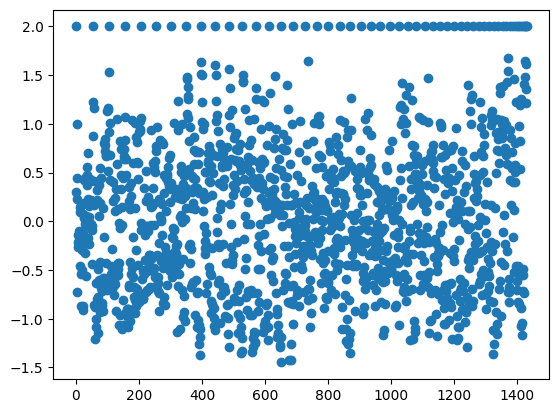

In [42]:
plt.scatter(np.arange(1431), X_n[0])

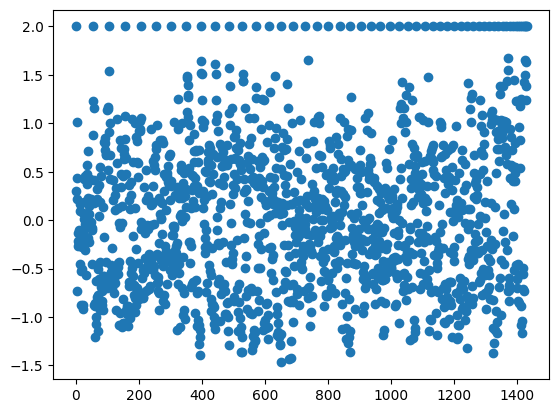

In [43]:
plt.scatter(np.arange(1431), X[0])

In [55]:
import logging
import argparse
from datetime import datetime

import pandas as pd
import numpy as np

import scipy.io

from utils.usp_utils import *

data_params = {}

lower = 1.5
upper = 2.5
step = 0.1

SNRs = np.round(np.arange(lower, upper+step, step), 1)

noise_dataset = 'fbirn'.upper()
signal_dataset = 'hcp'.upper()
n_folds = 7
num_noise = 1
log_level = 'INFO'

project_dir = '/data/users2/jwardell1/undersampling-project'

logging.basicConfig(level=log_level, format='%(asctime)s - %(levelname)s - %(message)s')

# Print the parsed arguments to verify
logging.info(f'Noise Interval: {SNRs}')
logging.info(f'Noise Dataset: {noise_dataset}')
logging.info(f'Signal Dataset: {signal_dataset}')
logging.info(f'Noise Iterations: {num_noise}')


data_params['noise_dataset'] = noise_dataset
data_params['signal_dataset'] = signal_dataset

signal_data = pd.read_pickle(f'{project_dir}/assets/data/{signal_dataset}_data.pkl')
noise_data = scipy.io.loadmat(f'{project_dir}/assets/data/{noise_dataset}_data.mat')

subjects = np.unique(signal_data['subject'])
data_params['subjects'] = subjects


if noise_dataset == "VAR":
    A = noise_data['A']
    u_rate = 1
    nstd = 1.0
    burn = 100
    threshold = 0.0001
    
    logging.debug(f'A - {A}')
    logging.debug(f'u_rate - {u_rate}')
    logging.debug(f'nstd - {nstd}')
    logging.debug(f'burn - {burn}')
    logging.debug(f'threshold - {threshold}')


    data_params['A'] = A
    data_params['u_rate'] = u_rate
    data_params['nstd'] = nstd
    data_params['burn'] = burn
    data_params['threshold'] = threshold

else:
    L = noise_data['L']
    covariance_matrix = noise_data['cov_mat']

    logging.debug(f'L {L}')
    logging.debug(f'covariance_matrix {covariance_matrix}')

    data_params['L'] = L
    data_params['covariance_matrix'] = covariance_matrix

if signal_dataset == 'OULU':
    undersampling_rate = 1
    NOISE_SIZE = 2961*2

if signal_dataset == 'SIMULATION':
    undersampling_rate = 1
    NOISE_SIZE = 18018 #might should write a function to compute this, it is LCM(t1*k1, t2*k2)

if signal_dataset == 'HCP':
    NOISE_SIZE = 1200
    undersampling_rate = 6



data_params['NOISE_SIZE'] = NOISE_SIZE
data_params['undersampling_rate'] = undersampling_rate





SNR = SNRs[0]

data_params['SNR'] = SNR


all_data = load_timecourses(signal_data, data_params)


data_df = pd.DataFrame(all_data)



################ windowing
sr1_data, sr2_data, add_data, concat_data, combcov_data = perform_windowing(data_df)


X_sr1, y_sr1, group_sr1 = parse_X_y_groups(pd.DataFrame(sr1_data), 'SR1')
X_sr2, y_sr2, group_sr2 = parse_X_y_groups(pd.DataFrame(sr2_data), 'SR2')
X_add, y_add, group_add = parse_X_y_groups(pd.DataFrame(add_data), 'Add')
X_concat, y_concat, group_concat = parse_X_y_groups(pd.DataFrame(concat_data), 'Concat')
X_combcov, y_combcov, group_combcov = parse_X_y_groups(pd.DataFrame(combcov_data), 'CombCov')


2024-10-07 16:27:29,005 - INFO - Noise Interval: [1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5]
2024-10-07 16:27:29,006 - INFO - Noise Dataset: FBIRN
2024-10-07 16:27:29,007 - INFO - Signal Dataset: HCP
2024-10-07 16:27:29,008 - INFO - Noise Iterations: 1


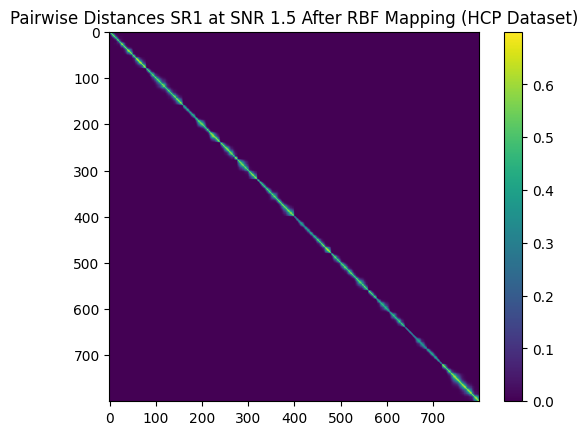

In [58]:
from sklearn.metrics.pairwise import rbf_kernel

dfs = {
    'SR1' : sr1_data,
    'SR2' : sr2_data,
    'Add' : add_data,
}

sr = 'SR1'
df = pd.DataFrame(dfs[sr])
X_n, y_n, g_n = parse_X_y_groups(df[df['target'] == '1'], sr)
X, y, g = parse_X_y_groups(df[df['target'] == '0'], sr)

X_n_rbf = rbf_kernel(X_n, X, gamma=gamma)
plt.clf()
plt.imshow(X_n_rbf)
plt.title(f'Pairwise Distances {sr} at SNR {SNR} After RBF Mapping (HCP Dataset)')
plt.colorbar()

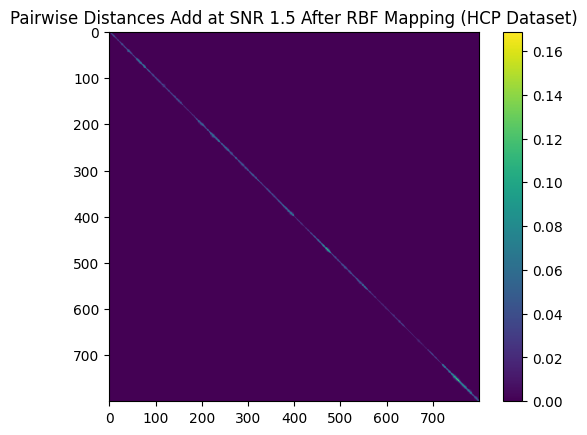

In [59]:
from sklearn.metrics.pairwise import rbf_kernel

dfs = {
    'SR1' : sr1_data,
    'SR2' : sr2_data,
    'Add' : add_data,
}

sr = 'Add'
df = pd.DataFrame(dfs[sr])
X_n, y_n, g_n = parse_X_y_groups(df[df['target'] == '1'], sr)
X, y, g = parse_X_y_groups(df[df['target'] == '0'], sr)

X_n_rbf = rbf_kernel(X_n, X, gamma=gamma)
plt.clf()
plt.imshow(X_n_rbf)
plt.title(f'Pairwise Distances {sr} at SNR {SNR} After RBF Mapping (HCP Dataset)')
plt.colorbar()

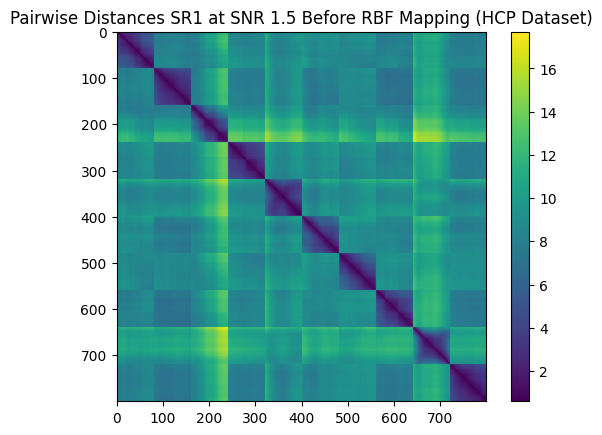

In [62]:
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import cdist

dfs = {
    'SR1' : sr1_data,
    'SR2' : sr2_data,
    'Add' : add_data,
}

sr = 'SR1'
df = pd.DataFrame(dfs[sr])
X_n, y_n, g_n = parse_X_y_groups(df[df['target'] == '1'], sr)
X, y, g = parse_X_y_groups(df[df['target'] == '0'], sr)

plt.clf()
plt.imshow(cdist(X_n, X, 'euclidean'))
plt.title(f'Pairwise Distances {sr} at SNR {SNR} Before RBF Mapping (HCP Dataset)')
plt.colorbar()

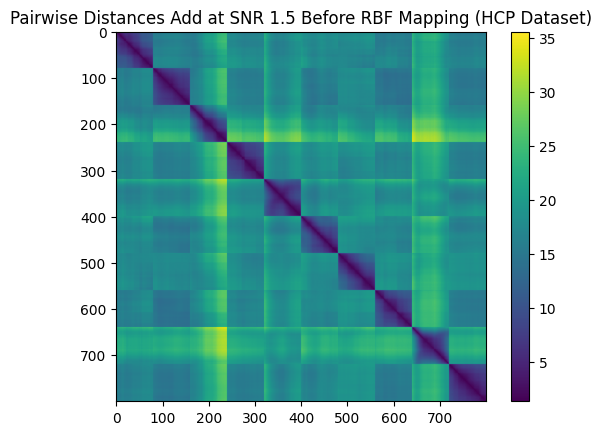

In [63]:
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import cdist

dfs = {
    'SR1' : sr1_data,
    'SR2' : sr2_data,
    'Add' : add_data,
}

sr = 'Add'
df = pd.DataFrame(dfs[sr])
X_n, y_n, g_n = parse_X_y_groups(df[df['target'] == '1'], sr)
X, y, g = parse_X_y_groups(df[df['target'] == '0'], sr)

plt.clf()
plt.imshow(cdist(X_n, X, 'euclidean'))
plt.title(f'Pairwise Distances {sr} at SNR {SNR} Before RBF Mapping (HCP Dataset)')
plt.colorbar()

In [64]:
from numpy import load

X_add = load('/data/users2/jwardell1/undersampling-project/X_add_snr_1.5.npz')

In [69]:
X_add['arr_2']

array([ 0,  0,  0, ..., 10, 10, 10])

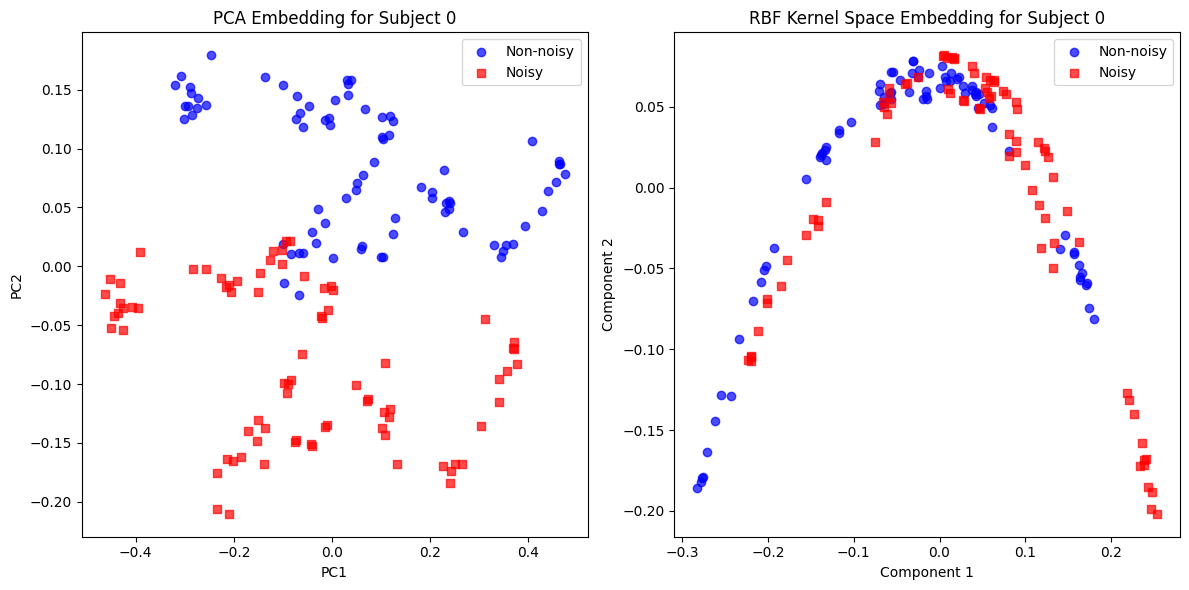

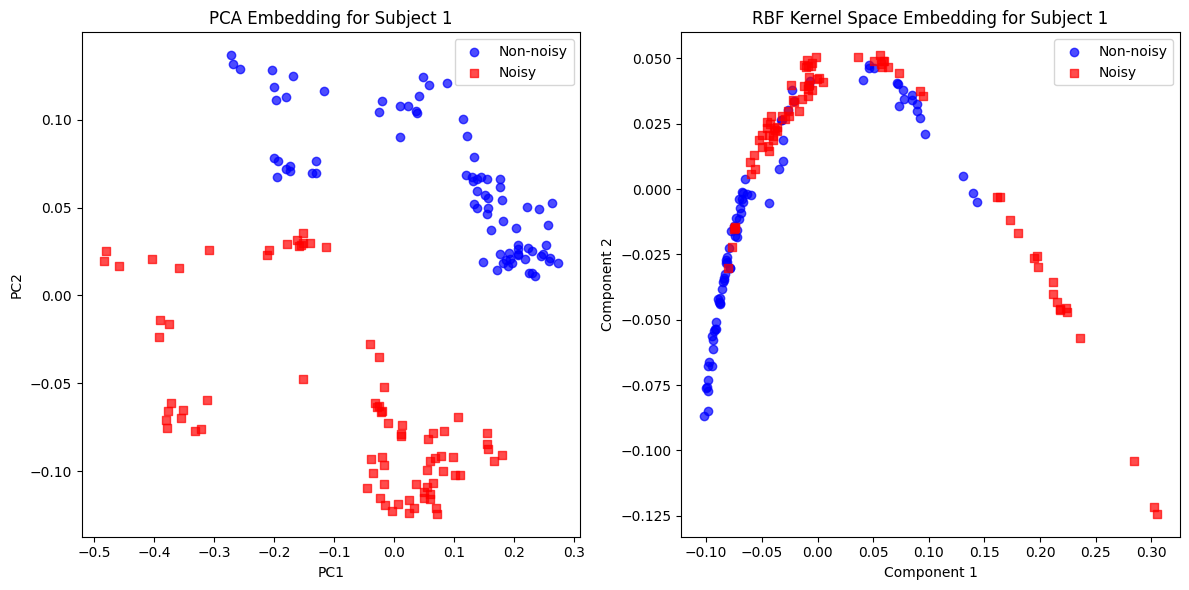

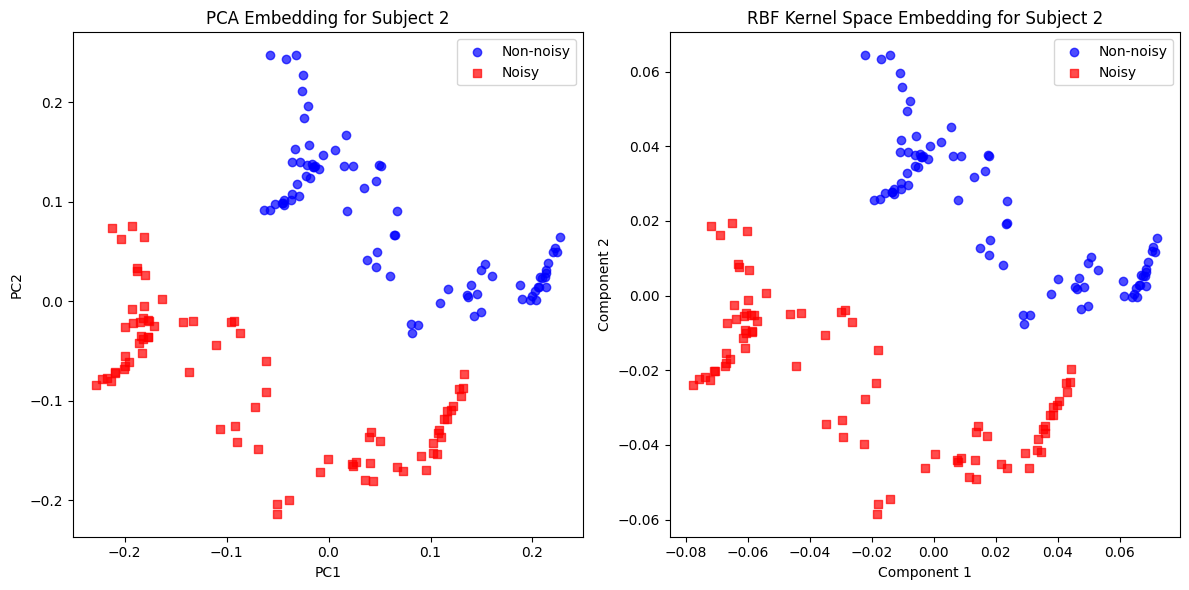

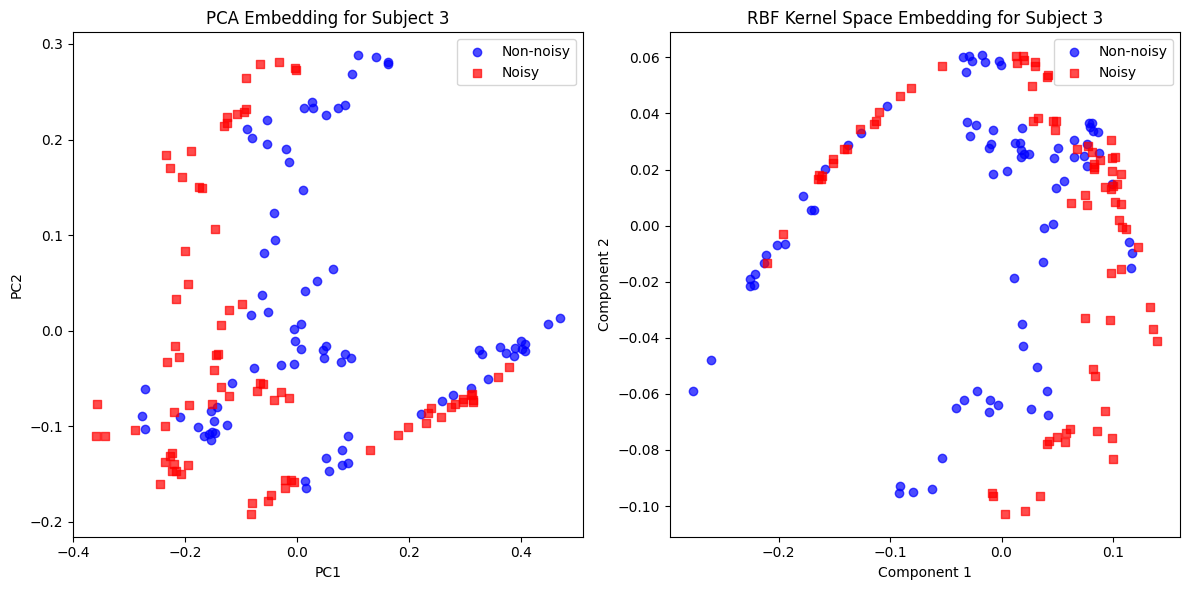

In [71]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt

# Load the data
data = np.load('/data/users2/jwardell1/undersampling-project/X_add_snr_1.5.npz')  # Replace with the path to your data file
X_add = data['arr_0']
y_add = data['arr_1']
group_add = data['arr_2']

# Set the gamma value for the RBF kernel
gamma = 0.1

# Function to plot PCA and RBF embeddings for a given subject
def plot_embeddings(subject_id, X_add, y_add, group_add, gamma):
    # Filter for the selected subject
    subject_mask = group_add.astype(str) == str(subject_id)
    X_subject = X_add[subject_mask]
    y_subject = y_add[subject_mask]
    
    # PCA embedding
    pca = PCA(n_components=2)
    X_pca_subject = pca.fit_transform(X_subject)
    
    # RBF kernel transformation and PCA for visualization
    X_rbf_subject = rbf_kernel(X_subject, gamma=gamma)
    X_rbf_pca_subject = pca.fit_transform(X_rbf_subject)
    
    # Plotting PCA and RBF embeddings
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # PCA plot
    ax1.scatter(X_pca_subject[y_subject == '0', 0], X_pca_subject[y_subject == '0', 1], marker='o', color='blue', label='Non-noisy', alpha=0.7)
    ax1.scatter(X_pca_subject[y_subject == '1', 0], X_pca_subject[y_subject == '1', 1], marker='s', color='red', label='Noisy', alpha=0.7)
    ax1.set_title(f'PCA Embedding for Subject {subject_id}')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.legend(loc='best')
    
    # RBF kernel plot
    ax2.scatter(X_rbf_pca_subject[y_subject == '0', 0], X_rbf_pca_subject[y_subject == '0', 1], marker='o', color='blue', label='Non-noisy', alpha=0.7)
    ax2.scatter(X_rbf_pca_subject[y_subject == '1', 0], X_rbf_pca_subject[y_subject == '1', 1], marker='s', color='red', label='Noisy', alpha=0.7)
    ax2.set_title(f'RBF Kernel Space Embedding for Subject {subject_id}')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    ax2.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

# Example usage: Plot for subjects 0, 1, 2, and 3
for subject in ['0', '1', '2', '3']:
    plot_embeddings(subject, X_add, y_add, group_add, gamma)
